Import packages

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, floor, sum as spark_sum, count as spark_count, when, mean, countDistinct, length, avg
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns 

Start spark session and load data from parquet

In [2]:
spark_session = (SparkSession.builder
                    .master('local[*]')
                    .config("spark.executor.memory", "8g")
                    .config("spark.driver.memory", "4g")
                    .appName('SparkAnalysis')
                    .getOrCreate())   

In [3]:
df = spark_session.read.parquet(
    "reviews-clean.parquet",
    header=True,
    inferSchema=True
)

df.printSchema()

root
 |-- recommendation_id: integer (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- game_title: string (nullable = true)
 |-- author_steam_id: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_lifetime: float (nullable = true)
 |-- author_playtime_at_review: float (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- is_voted_up: boolean (nullable = true)
 |-- num_votes_up: integer (nullable = true)
 |-- num_votes_funny: integer (nullable = true)
 |-- weighted_vote_score: float (nullable = true)
 |-- num_comment: integer (nullable = true)
 |-- is_purchased: boolean (nullable = true)
 |-- is_received_for_free: boolean (nullable = true)
 |-- is_written_during_early_access: boolean (null

In [4]:
df.show()

+-----------------+------+--------------------+-----------------+----------------------+------------------+------------------------+-------------------------+-------------------+--------+--------------------+-------------------+-------------------+-----------+------------+---------------+-------------------+-----------+------------+--------------------+------------------------------+----------------+-----------------------+-----------------------+
|recommendation_id|app_id|          game_title|  author_steam_id|author_num_games_owned|author_num_reviews|author_playtime_lifetime|author_playtime_at_review| author_last_played|language|              review|         created_at|         updated_at|is_voted_up|num_votes_up|num_votes_funny|weighted_vote_score|num_comment|is_purchased|is_received_for_free|is_written_during_early_access|reviews_per_game|review_total_engagement|review_comment_per_vote|
+-----------------+------+--------------------+-----------------+----------------------+--------

In [ ]:
# Ids
COL_RECOMMENDATION_ID = "recommendation_id"
COL_APP_ID = "app_id"
COL_AUTHOR_STEAM_ID = "author_steam_id" 

# Game
COL_GAME_TITLE = "game_title"

# Author
COL_AUTHOR_NUM_GAMES = "author_num_games_owned"
COL_AUTHOR_NUM_REVIEWS = "author_num_reviews"
COL_AUTHOR_PLAYTIME_LIFETIME = "author_playtime_lifetime" # lifetime playtime tracked in game (originaly in minutes, later converted to hours)
COL_AUTHOR_PLAYTIME_AT_REVIEW = "author_playtime_at_review" # playtime when the review was written (originaly in minutes, later converted to hours)
COL_AUTHOR_LAST_PLAYED = "author_last_played"

AUTHOR_COLUMNS = [COL_AUTHOR_NUM_GAMES, COL_AUTHOR_NUM_REVIEWS, COL_AUTHOR_PLAYTIME_LIFETIME, COL_AUTHOR_PLAYTIME_AT_REVIEW, COL_AUTHOR_LAST_PLAYED]

# Review details
COL_LANGUAGE = "language"
COL_REVIEW = "review" # review text
COL_CREATED_AT = "created_at"
COL_UPDATED_AT = "updated_at"
COL_IS_VOTED_UP = "is_voted_up" # if the review was positive or negative

REVIEW_DETAILS_COLUMNS = [COL_LANGUAGE, COL_REVIEW, COL_CREATED_AT, COL_UPDATED_AT, COL_IS_VOTED_UP]

# Players response to the review
COL_NUM_VOTES_UP = "num_votes_up" # number of people who voted the review up
COL_NUM_VOTES_FUNNY = "num_votes_funny" # number of people who voted the review funny
COL_NUM_COMMENTS = "num_comment" # number of comments to the review

PLAYERS_RESPONSE_COLUMNS = [COL_NUM_VOTES_UP, COL_NUM_VOTES_FUNNY, COL_NUM_COMMENTS]

# Game state at a time of the review
COL_IS_PURCHASED = "is_purchased" # if the user purchased the game on Steam
COL_IS_RECEIVED_FOR_FREE = "is_received_for_free" # true if the user checked a box saying they got the app for free
COL_IS_WRITTEN_DURING_EARLY_ACCESS = "is_written_during_early_access" # if the user posted this review while the game was in Early Access

PURCHASE_STATE_COLUMNS = [COL_IS_PURCHASED, COL_IS_RECEIVED_FOR_FREE, COL_IS_WRITTEN_DURING_EARLY_ACCESS]

COL_REVIEWS_PER_GAME = "reviews_per_game" # number of reviews player has written per game they own (supposed to show normilized user activity)
COL_REVIEW_TOTAL_ENGAGEMENT = "review_total_engagement" # number of all votes up and funny (sadly votes down are not collected)
COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE = "review_comment_per_vote" # number of comments per vote (supposed to show normilized review comment engagement)

# DID NOT ADD THIS COLUMN RIGHT AWAY
# A metric for how engaging a person is
COL_AVERAGE_REVIEW_ENGAGEMENT = "average_review_engagement" # COL_REVIEW_TOTAL_ENGAGEMENT / COL_AUTHOR_NUM_REVIEWS

Two possible goals:
1. Encourage people to write more comments(for this we need to analyse and pin point where the system fails)
2. Predict the usefulness of the comment before people get exposed to it to set a priority in showing order

In [6]:
empty_reviews_with_engagement = df.filter((col(COL_REVIEW) == "") & (col(COL_NUM_VOTES_UP) + col(COL_NUM_VOTES_UP) + col(COL_NUM_COMMENTS) > 0))

In [ ]:
count = empty_reviews_with_engagement.count()

print(f"Number of empty reviews with engagement: {count}")

Number of empty reviews with engagement: 8035


In [7]:
dead_reviews = df.filter((col(COL_REVIEW) == "") | (col(COL_NUM_VOTES_UP) + col(COL_NUM_VOTES_FUNNY) + col(COL_NUM_COMMENTS) <= 0))

In [15]:
count = dead_reviews.count()

print(f"Number of dead reviews: {count}")

Number of dead reviews: 70070978


In [8]:
reviews_from_dead_accounts = df.filter((col(COL_AUTHOR_NUM_GAMES) == 0) | (col(COL_AUTHOR_PLAYTIME_LIFETIME) == 0) | (col(COL_AUTHOR_PLAYTIME_AT_REVIEW) == 0) | (col(COL_AUTHOR_LAST_PLAYED).isNull()))

In [ ]:
count = reviews_from_dead_accounts.count()

print(f"Number of reviews from dead accounts: {count}")

Number of dead reviews: 55264234


In [5]:
review_by_dead_account_condition = ((col(COL_AUTHOR_NUM_GAMES) == 0) | (col(COL_AUTHOR_PLAYTIME_LIFETIME) == 0) | (col(COL_AUTHOR_PLAYTIME_AT_REVIEW) == 0) | (col(COL_AUTHOR_LAST_PLAYED).isNull()))
dead_reviews_condition = ((col(COL_REVIEW) == "") | (col(COL_NUM_VOTES_UP) + col(COL_NUM_VOTES_FUNNY) + col(COL_NUM_COMMENTS) <= 0))

combined_dead_reviews = df.filter(dead_reviews_condition | review_by_dead_account_condition)

In [6]:
dead_reviews_by_active_account = df.filter(dead_reviews_condition & ~review_by_dead_account_condition)

In [12]:
count = dead_reviews_by_active_account.count()

print(f"Number of dead reviews by active accounts: {count}")

Number of dead reviews by active accounts: 32834891


In [7]:
clean_reviews = df.filter(~dead_reviews_condition & ~review_by_dead_account_condition)

In [27]:
clean_reviews = clean_reviews.repartition(32)

In [17]:
count = combined_dead_reviews.count()

print(f"Number of all dead reviews: {count}")

Number of all dead reviews: 88099125


In [11]:
clean_reviews.withColumn("review_length", length(col(COL_REVIEW))).describe("review_length").show()

+-------+------------------+
|summary|     review_length|
+-------+------------------+
|  count|          18950075|
|   mean|202.19513257863096|
| stddev| 4506.646854796921|
|    min|                 1|
|    max|           7573499|
+-------+------------------+



In [12]:
clean_reviews_with_length_cleared = clean_reviews.filter(length(col(COL_REVIEW)) < 10000)

# 0.1. Correlation analysis

In [ ]:
columns_to_correlate = [
    COL_AUTHOR_NUM_GAMES, COL_AUTHOR_NUM_REVIEWS, COL_AUTHOR_PLAYTIME_LIFETIME, COL_AUTHOR_PLAYTIME_AT_REVIEW,
    COL_NUM_VOTES_UP, COL_NUM_VOTES_FUNNY, COL_NUM_COMMENTS,
    ]

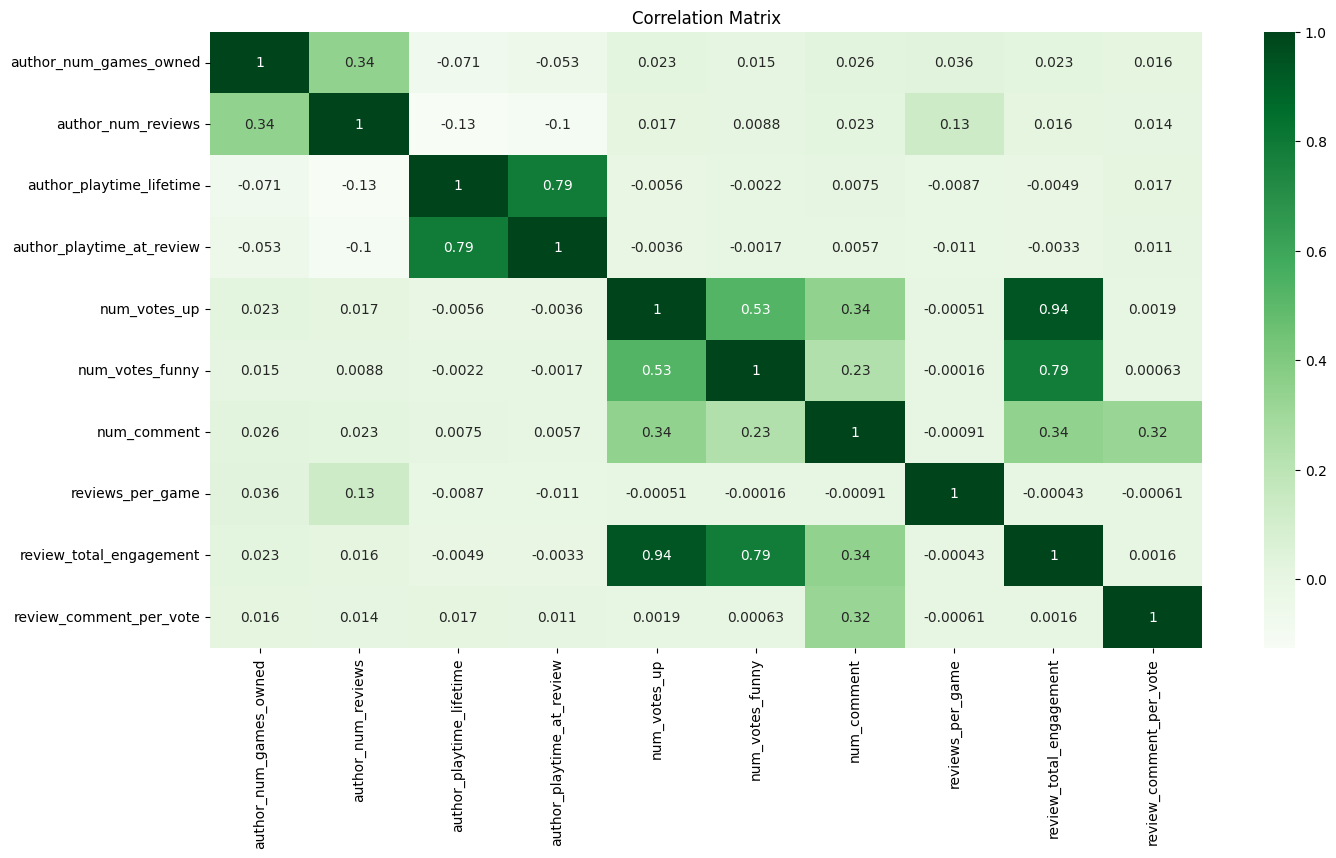

In [ ]:
assembler = VectorAssembler(inputCols=columns_to_correlate, outputCol="features")
df_vector = assembler.transform(df).select("features")

matrix = Correlation.corr(df_vector, "features").head()[0] 

corr_matrix = matrix.toArray()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=columns_to_correlate, index=columns_to_correlate)

plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values, cmap="Greens", annot=True)
plt.title("Correlation Matrix")
plt.show()

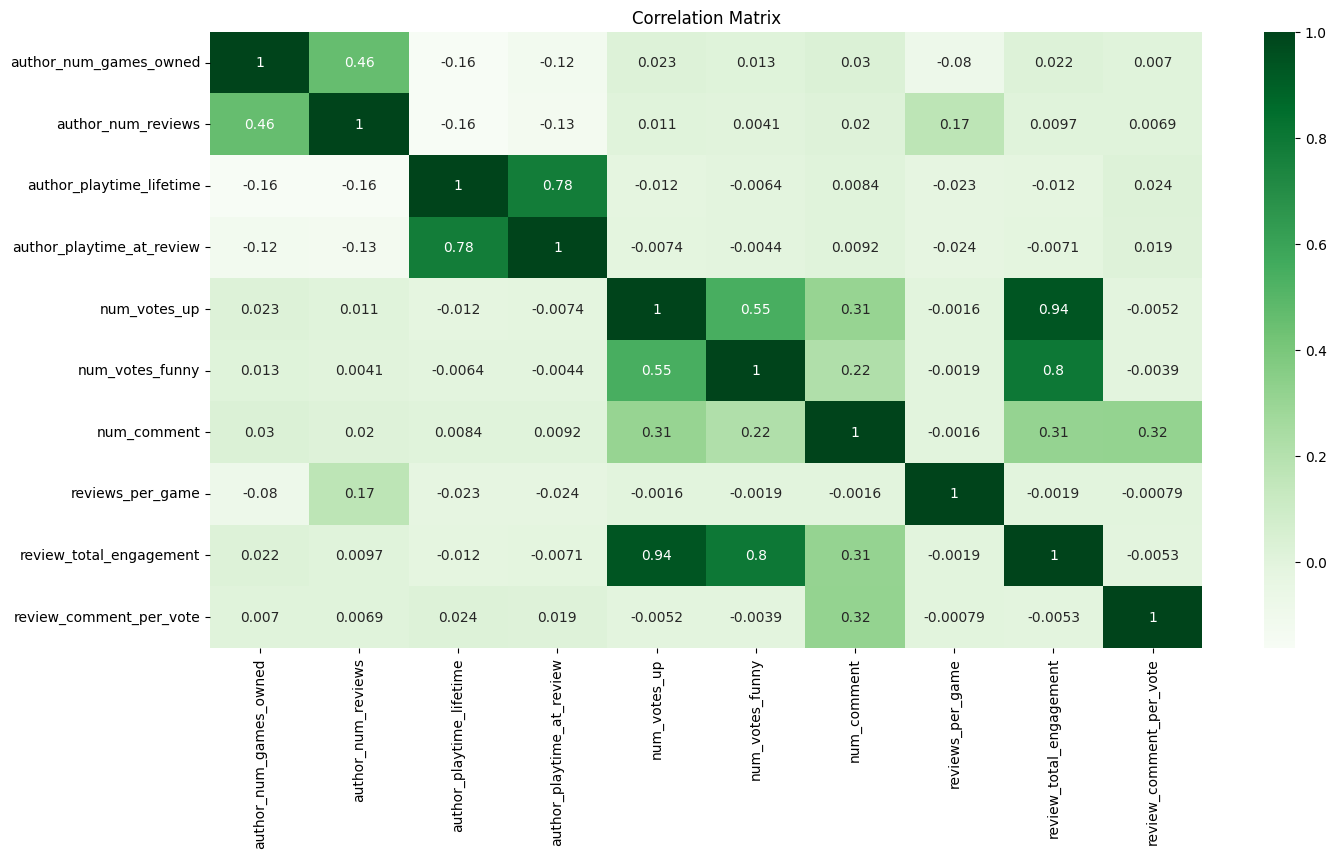

In [28]:
assembler = VectorAssembler(inputCols=columns_to_correlate, outputCol="features")
df_vector = assembler.transform(clean_reviews).select("features")

matrix = Correlation.corr(df_vector, "features").head()[0] 

corr_matrix = matrix.toArray()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=columns_to_correlate, index=columns_to_correlate)

plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values, cmap="Greens", annot=True)
plt.title("Correlation Matrix")
plt.show()

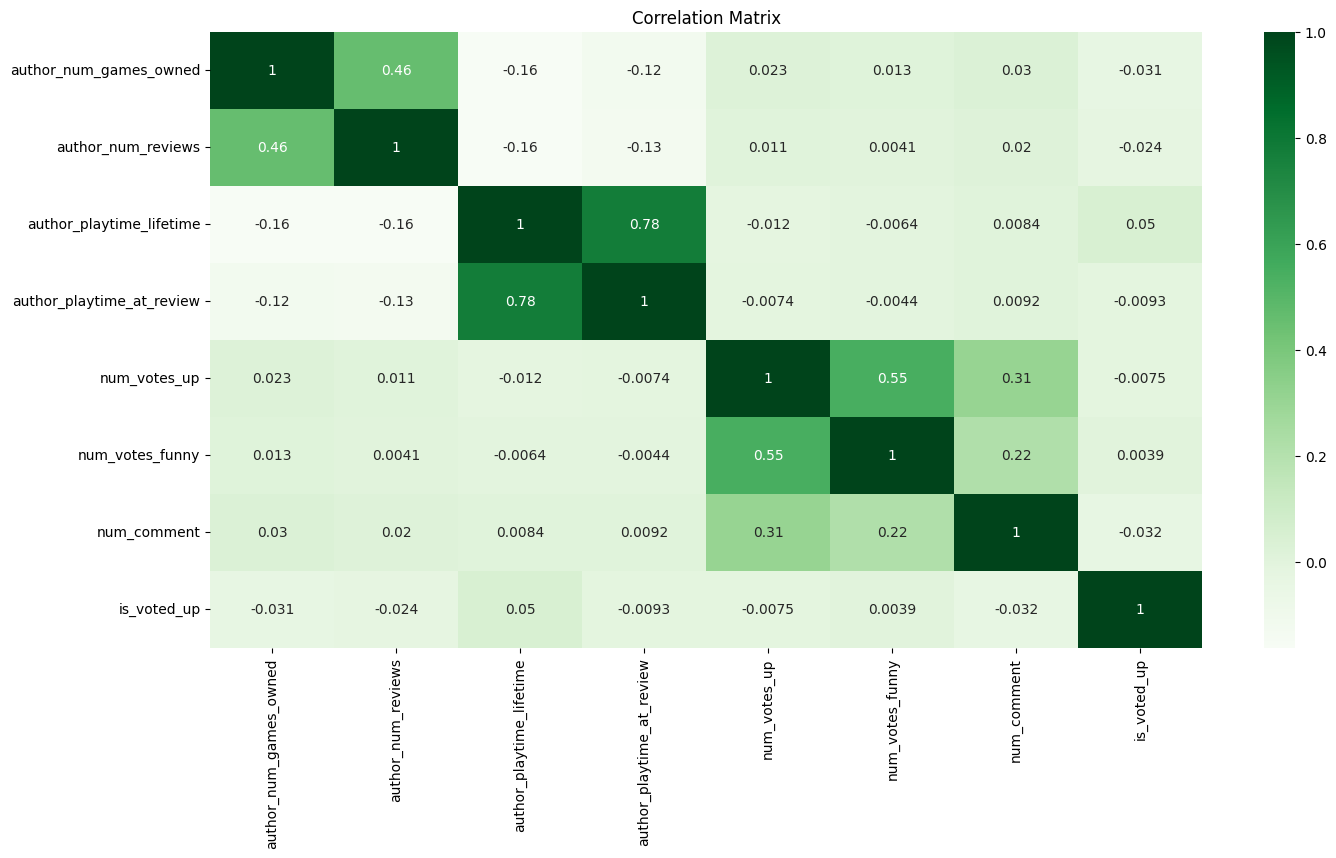

In [29]:
columns_to_correlate = [
    COL_AUTHOR_NUM_GAMES, COL_AUTHOR_NUM_REVIEWS, COL_AUTHOR_PLAYTIME_LIFETIME, COL_AUTHOR_PLAYTIME_AT_REVIEW,
    COL_NUM_VOTES_UP, COL_NUM_VOTES_FUNNY, COL_NUM_COMMENTS,
    COL_IS_VOTED_UP
]

assembler = VectorAssembler(inputCols=columns_to_correlate, outputCol="features")
df_vector = assembler.transform(clean_reviews).select("features")

matrix = Correlation.corr(df_vector, "features").head()[0] 

corr_matrix = matrix.toArray()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=columns_to_correlate, index=columns_to_correlate)

plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values, cmap="Greens", annot=True)
plt.title("Correlation Matrix")
plt.show()

# 0.2. Messy ploting

In [11]:
pandas_df = (clean_reviews.select([COL_AUTHOR_NUM_GAMES, COL_AUTHOR_NUM_REVIEWS])).toPandas()

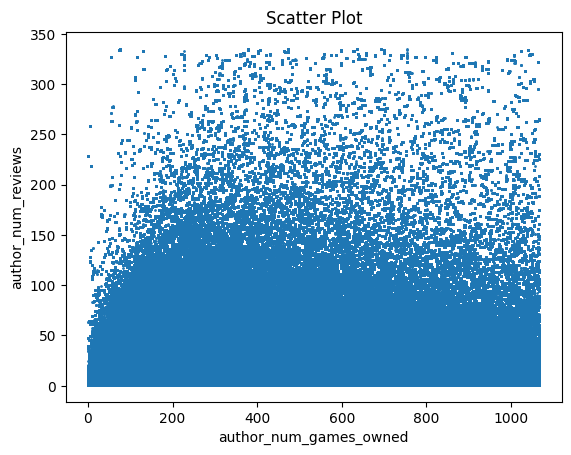

In [ ]:
plt.scatter(pandas_df[COL_AUTHOR_NUM_GAMES], pandas_df[COL_AUTHOR_NUM_REVIEWS], s=1)
plt.title("Scatter Plot")
plt.xlabel(COL_AUTHOR_NUM_GAMES)
plt.ylabel(COL_AUTHOR_NUM_REVIEWS)
plt.show()

In [15]:
pandas_df = (clean_reviews.select([COL_AUTHOR_PLAYTIME_LIFETIME, COL_AUTHOR_NUM_REVIEWS])).toPandas()

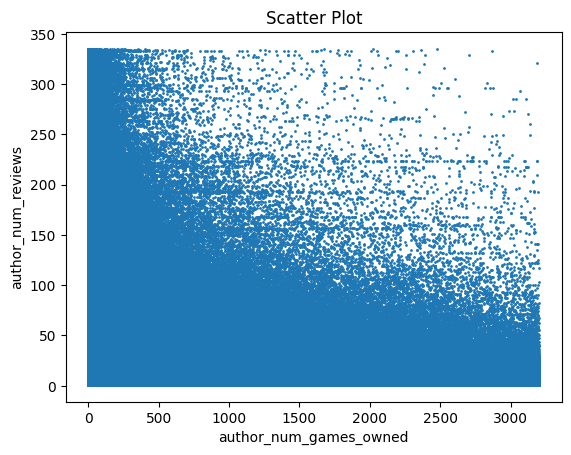

In [ ]:
plt.scatter(pandas_df[COL_AUTHOR_PLAYTIME_LIFETIME], pandas_df[COL_AUTHOR_NUM_REVIEWS], s=1)
plt.title("Scatter Plot")
plt.xlabel(COL_AUTHOR_NUM_GAMES)
plt.ylabel(COL_AUTHOR_NUM_REVIEWS)
plt.show()

In [17]:
pandas_df = (clean_reviews.select([COL_NUM_VOTES_UP, COL_NUM_VOTES_FUNNY])).toPandas()

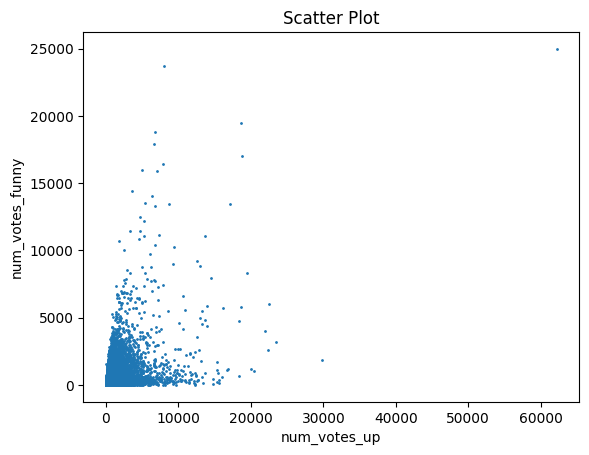

In [ ]:
plt.scatter(pandas_df[COL_NUM_VOTES_UP], pandas_df[COL_NUM_VOTES_FUNNY], s=1)
plt.title("Scatter Plot")
plt.xlabel(COL_NUM_VOTES_UP)
plt.ylabel(COL_NUM_VOTES_FUNNY)
plt.show()

# 1.0 Grouped analysis

Find Trend between number of games owned and number of reviews

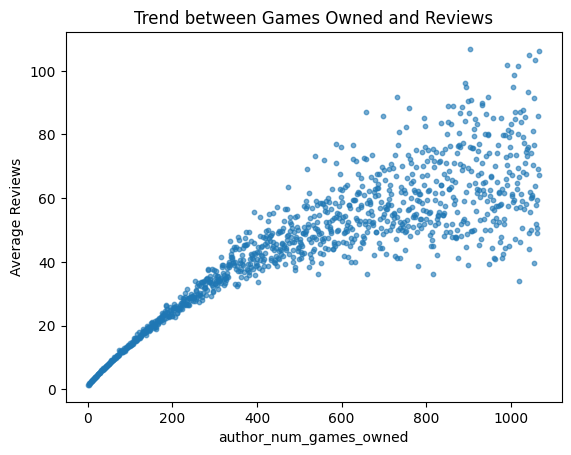

In [ ]:
games_vs_reviews = clean_reviews.groupBy(COL_AUTHOR_NUM_GAMES).agg(
    mean(COL_AUTHOR_NUM_REVIEWS).alias("avg_reviews")
).toPandas()

plt.scatter(
    games_vs_reviews[COL_AUTHOR_NUM_GAMES],
    games_vs_reviews["avg_reviews"],
    s=10, alpha=0.6
)
plt.title("Trend between Games Owned and Reviews")
plt.xlabel(COL_AUTHOR_NUM_GAMES)
plt.ylabel("Average Reviews")
plt.show()

Find relation between playtime and number of reviews

In [72]:
playtime_data = clean_reviews.groupBy(COL_AUTHOR_STEAM_ID).agg(
    mean(COL_AUTHOR_PLAYTIME_LIFETIME).alias("lifetime_playtime"),
    mean(COL_AUTHOR_PLAYTIME_AT_REVIEW).alias("avg_playtime_at_review"),
    spark_count("*").alias("num_reviews_by_author")
)

In [ ]:
playtime_data_pandas = playtime_data.toPandas()

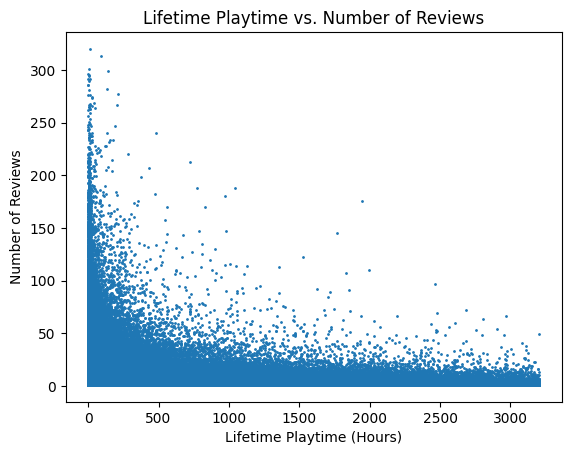

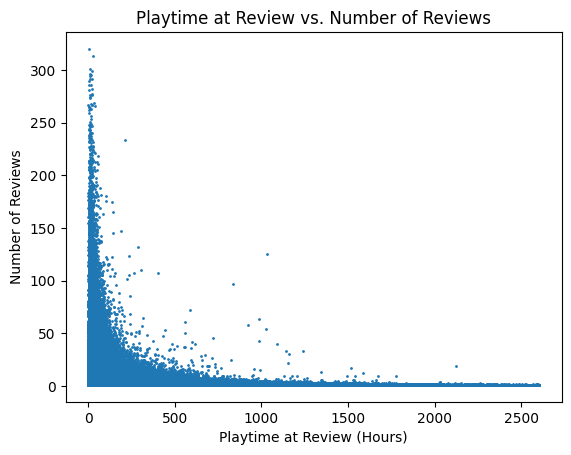

In [69]:
plt.scatter(playtime_data_pandas["lifetime_playtime"], playtime_data_pandas["num_reviews_by_author"], s=1)
plt.title("Lifetime Playtime vs. Number of Reviews")
plt.xlabel("Lifetime Playtime (Hours)")
plt.ylabel("Number of Reviews")
plt.show()

plt.scatter(playtime_data_pandas["avg_playtime_at_review"], playtime_data_pandas["num_reviews_by_author"], s=1)
plt.title("Playtime at Review vs. Number of Reviews")
plt.xlabel("Playtime at Review (Hours)")
plt.ylabel("Number of Reviews")
plt.show()


Find relation between playtime and number of reviews and compare positive to negative reviews

In [10]:
playtime_data_voted = clean_reviews.groupBy(COL_AUTHOR_STEAM_ID).agg(
    mean(COL_AUTHOR_PLAYTIME_AT_REVIEW).alias("avg_playtime_at_review"),
    mean(col(COL_IS_VOTED_UP).cast("int")).alias("review_sentiment"),
    spark_count("*").alias("num_reviews_by_author")
)

In [ ]:
playtime_data_voted_pandas = playtime_data_voted.toPandas()

In [12]:
playtime_data_voted_pandas_sample = playtime_data_voted_pandas.sample(frac=0.1)

In [ ]:
positive_reviews = playtime_data_voted_pandas_sample[playtime_data_voted_pandas_sample["review_sentiment"] > 0.5]
negative_reviews = playtime_data_voted_pandas_sample[playtime_data_voted_pandas_sample["review_sentiment"] <= 0.5]

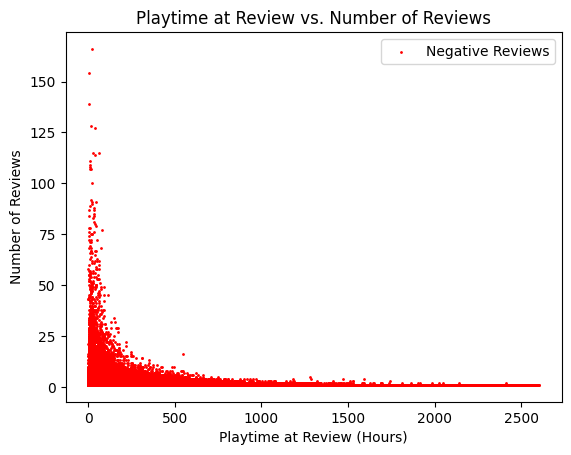

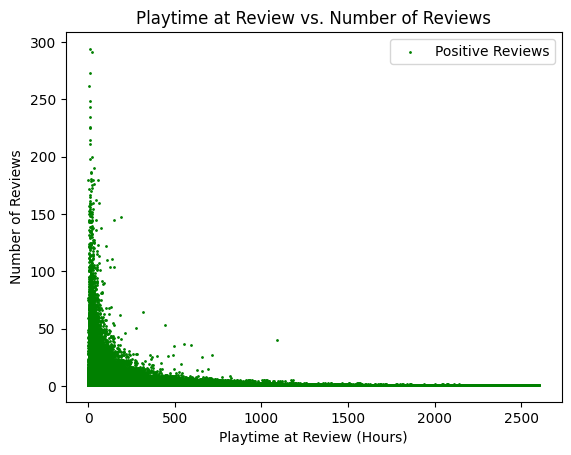

In [24]:
plt.scatter(negative_reviews["avg_playtime_at_review"], negative_reviews["num_reviews_by_author"], s=1, label="Negative Reviews", color="red")
plt.title("Playtime at Review vs. Number of Reviews")
plt.xlabel("Playtime at Review (Hours)")
plt.ylabel("Number of Reviews")
plt.legend()
plt.show()

plt.scatter(positive_reviews["avg_playtime_at_review"], positive_reviews["num_reviews_by_author"], s=1, label="Positive Reviews", color="green")
plt.title("Playtime at Review vs. Number of Reviews")
plt.xlabel("Playtime at Review (Hours)")
plt.ylabel("Number of Reviews")
plt.legend()
plt.show()

Find Average Number of Reviews per Playtime at Review binned

In [ ]:
playtime_bins = clean_reviews.withColumn(
    "lifetime_playtime_hours", floor(col(COL_AUTHOR_PLAYTIME_LIFETIME))
).groupBy("lifetime_playtime_hours").agg(
    spark_count("*").alias("num_reviews"),
    countDistinct(COL_AUTHOR_STEAM_ID).alias("num_authors")
).withColumn(
    "avg_reviews_per_author", col("num_reviews") / col("num_authors")
)


In [ ]:
playtime_bins_pandas = playtime_bins.toPandas()
playtime_bins_pandas = playtime_bins_pandas.sort_values("lifetime_playtime_hours")

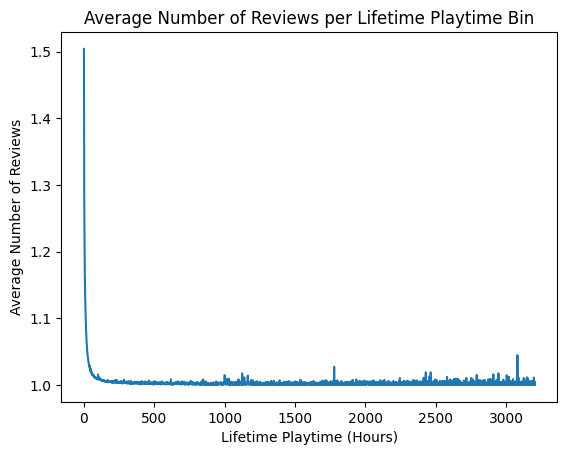

In [ ]:
plt.plot(playtime_bins_pandas["lifetime_playtime_hours"], playtime_bins_pandas["avg_reviews_per_author"])
plt.title("Average Number of Reviews per Lifetime Playtime Bin")
plt.xlabel("Lifetime Playtime (Hours)")
plt.ylabel("Average Number of Reviews")
plt.show()

In [ ]:
playtime_at_review_bins = clean_reviews.withColumn(
    "playtime_at_review_hours", floor(col(COL_AUTHOR_PLAYTIME_AT_REVIEW))
).groupBy("playtime_at_review_hours").agg(
    spark_count("*").alias("num_reviews"),
    countDistinct(COL_AUTHOR_STEAM_ID).alias("num_authors")
).withColumn(
    "avg_reviews_per_author", col("num_reviews") / col("num_authors")
)

In [ ]:
playtime_at_review_bins_pandas = playtime_at_review_bins.toPandas()
playtime_at_review_bins_pandas = playtime_at_review_bins_pandas.sort_values("playtime_at_review_hours")

this peak can make it seem as if people are more likely to write a review if they played <30 hours which is a great oportunity to encourage old players to write reviews, but this could be explained by most negetive reviews being in that range  

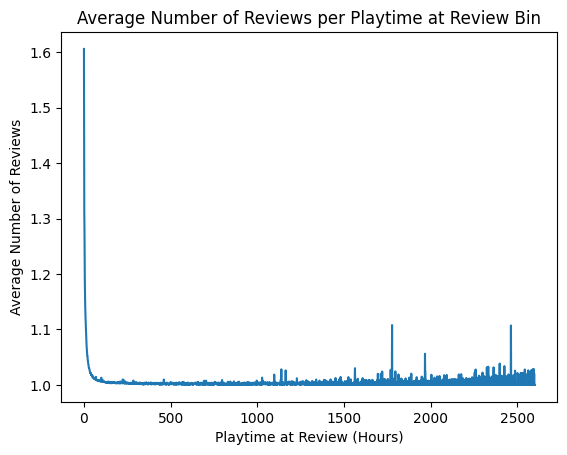

In [ ]:
plt.plot(playtime_at_review_bins_pandas["playtime_at_review_hours"], playtime_at_review_bins_pandas["avg_reviews_per_author"])
plt.title("Average Number of Reviews per Playtime at Review Bin")
plt.xlabel("Playtime at Review (Hours)")
plt.ylabel("Average Number of Reviews")
plt.show()

Find Average Number of Reviews per Playtime at Review Bin and compare plots for positive and negative reviews

In [ ]:
playtime_at_review_with_sentiment_bins = clean_reviews.withColumn(
    "playtime_at_review_hours", floor(col(COL_AUTHOR_PLAYTIME_AT_REVIEW))
).groupBy("playtime_at_review_hours").agg(
    spark_count("*").alias("num_reviews"),
    countDistinct(COL_AUTHOR_STEAM_ID).alias("num_authors"),
    spark_count(when(col(COL_IS_VOTED_UP) == True, 1)).alias("num_positive_reviews"),
    spark_count(when(col(COL_IS_VOTED_UP) == False, 1)).alias("num_negative_reviews"),
).withColumn(
    "avg_reviews_per_author", col("num_reviews") / col("num_authors")
).withColumn(
    "avg_positive_reviews_per_author", col("num_positive_reviews") / col("num_authors")
).withColumn(
    "avg_negative_reviews_per_author", col("num_negative_reviews") / col("num_authors")
)

In [ ]:
playtime_at_review_with_sentiment_bins_pandas = playtime_at_review_with_sentiment_bins.toPandas()
playtime_at_review_with_sentiment_bins_pandas = playtime_at_review_with_sentiment_bins_pandas.sort_values("playtime_at_review_hours")

It would be better to have data about players who have played the game but haven't left any reviews for better picture

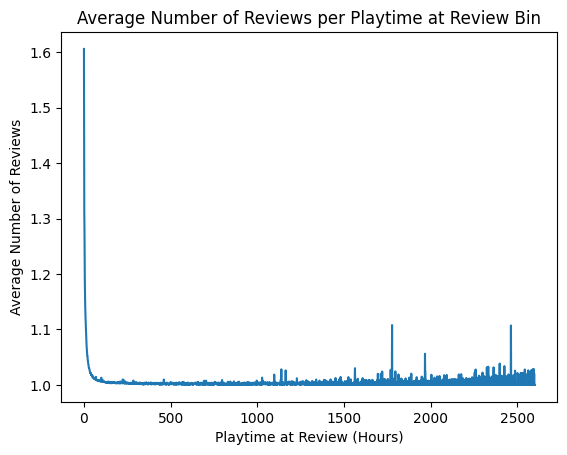

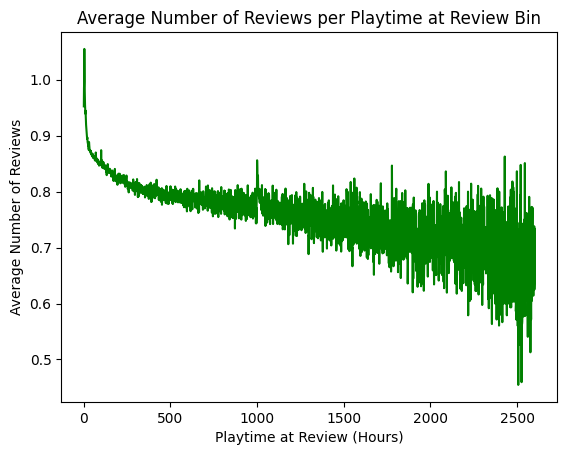

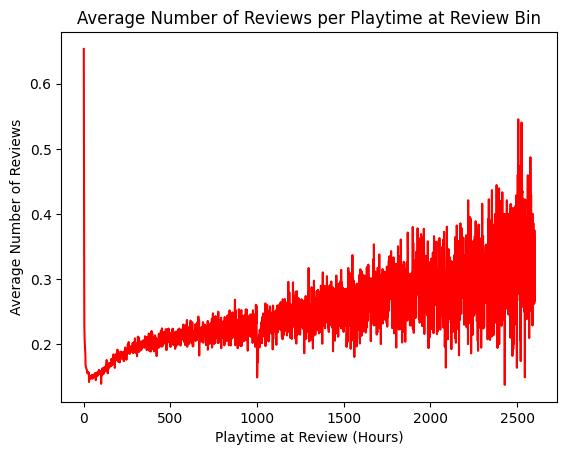

In [ ]:
plt.plot(playtime_at_review_with_sentiment_bins_pandas["playtime_at_review_hours"], playtime_at_review_with_sentiment_bins_pandas["avg_reviews_per_author"])
plt.title("Average Number of Reviews per Playtime at Review Bin")
plt.xlabel("Playtime at Review (Hours)")
plt.ylabel("Average Number of Reviews")
plt.show()

plt.plot(playtime_at_review_with_sentiment_bins_pandas["playtime_at_review_hours"], playtime_at_review_with_sentiment_bins_pandas["avg_positive_reviews_per_author"], color="green")
plt.title("Average Number of Positive Reviews per Playtime at Review Bin")
plt.xlabel("Playtime at Review (Hours)")
plt.ylabel("Average Number of Positive Reviews")
plt.show()

plt.plot(playtime_at_review_with_sentiment_bins_pandas["playtime_at_review_hours"], playtime_at_review_with_sentiment_bins_pandas["avg_negative_reviews_per_author"], color="red")
plt.title("Average Number of Negative Reviews per Playtime at Review Bin")
plt.xlabel("Playtime at Review (Hours)")
plt.ylabel("Average Number of Negative Reviews")
plt.show()

Find Average Percent Positive Reviews by Number of Games Owned

In [ ]:
avg_positive_reviews_by_games = clean_reviews.groupBy(COL_AUTHOR_NUM_GAMES).agg(
    mean(col(COL_IS_VOTED_UP).cast("int")).alias("avg_percent_positive_reviews"),
)

In [ ]:
avg_positive_reviews_by_games_pandas = avg_positive_reviews_by_games.toPandas()
avg_positive_reviews_by_games_pandas = avg_positive_reviews_by_games_pandas.sort_values(COL_AUTHOR_NUM_GAMES)

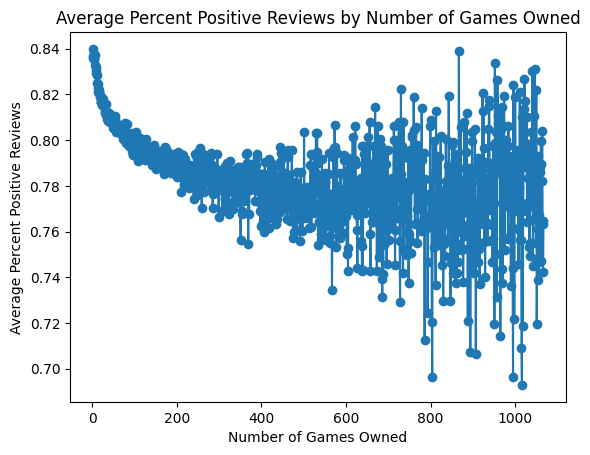

In [ ]:
plt.plot(avg_positive_reviews_by_games_pandas[COL_AUTHOR_NUM_GAMES], avg_positive_reviews_by_games_pandas["avg_percent_positive_reviews"], marker='o')
plt.title("Average Percent Positive Reviews by Number of Games Owned")
plt.xlabel("Number of Games Owned")
plt.ylabel("Average Percent Positive Reviews")
plt.show()

Find Average Percent Positive Reviews by Binned Playtime

In [ ]:
bin_size = 10


binned_reviews = clean_reviews.withColumn(
    "playtime_bin", (col(COL_AUTHOR_PLAYTIME_LIFETIME) / bin_size).cast("int") * bin_size
)

In [ ]:
avg_positive_reviews_by_playtime = binned_reviews.groupBy("playtime_bin").agg(
    mean(col(COL_IS_VOTED_UP).cast("int")).alias("avg_percent_positive_reviews"),
    spark_count("*").alias("num_reviews")
)

In [ ]:
avg_positive_reviews_by_playtime_pandas = avg_positive_reviews_by_playtime.toPandas()
avg_positive_reviews_by_playtime_pandas = avg_positive_reviews_by_playtime_pandas.sort_values("playtime_bin")

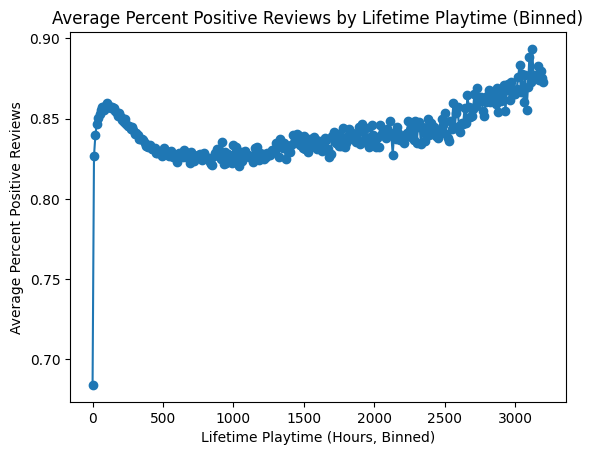

In [ ]:
plt.plot(avg_positive_reviews_by_playtime_pandas["playtime_bin"], avg_positive_reviews_by_playtime_pandas["avg_percent_positive_reviews"], marker='o')
plt.title("Average Percent Positive Reviews by Lifetime Playtime (Binned)")
plt.xlabel("Lifetime Playtime (Hours, Binned)")
plt.ylabel("Average Percent Positive Reviews")
plt.show()

# 1.1 Now not so clean data

Compare statistics of dead reviews by active accounts and clean reviews

In [ ]:
summary_stats = dead_reviews_by_active_account.select(
    COL_REVIEWS_PER_GAME, 
    COL_AUTHOR_NUM_GAMES, 
    COL_AUTHOR_NUM_REVIEWS, 
    COL_AUTHOR_PLAYTIME_LIFETIME, 
    COL_AUTHOR_PLAYTIME_AT_REVIEW
).summary()

summary_stats.show()

+-------+------------------+----------------------+------------------+------------------------+-------------------------+
|summary|  reviews_per_game|author_num_games_owned|author_num_reviews|author_playtime_lifetime|author_playtime_at_review|
+-------+------------------+----------------------+------------------+------------------------+-------------------------+
|  count|          32834891|              32834891|          32834891|                32834891|                 32834891|
|   mean|0.1839462376504478|     133.0757976933744|15.052322725846722|      212.52220309094335|       101.23948926710032|
| stddev|0.5331958132227917|    167.01460643613663| 27.04522040112301|       436.9521083708276|       253.81072514665743|
|    min|      9.3720714E-4|                     1|                 1|             0.016666668|              0.016666668|
|    25%|          0.046875|                    30|                 2|                   11.15|                 5.016667|
|    50%|       0.104477

In [ ]:
summary_stats = clean_reviews.select(
    COL_REVIEWS_PER_GAME, 
    COL_AUTHOR_NUM_GAMES, 
    COL_AUTHOR_NUM_REVIEWS, 
    COL_AUTHOR_PLAYTIME_LIFETIME, 
    COL_AUTHOR_PLAYTIME_AT_REVIEW
).summary()

summary_stats.show()

+-------+------------------+----------------------+------------------+------------------------+-------------------------+
|summary|  reviews_per_game|author_num_games_owned|author_num_reviews|author_playtime_lifetime|author_playtime_at_review|
+-------+------------------+----------------------+------------------+------------------------+-------------------------+
|  count|          18950075|              18950075|          18950075|                18950075|                 18950075|
|   mean|0.1567401255530645|    193.32646841767118|21.471683093602532|       237.7010037615701|       103.01880588879274|
| stddev|0.5363376356704116|     205.1588254815198| 35.75832707197932|       494.4621908358598|         259.489458852037|
|    min|      9.3720714E-4|                     1|                 1|             0.016666668|              0.016666668|
|    25%|              0.04|                    52|                 3|               7.9333334|                      3.8|
|    50%|         0.0882

# 2. Affects of columns on usefullness of the review:

Create a metric for how engaging a person is (average review engagement = total review engagement / number of reviews)

Calculate Average Review Engagement (metric for how engaging a person is)

In [ ]:
engagement_metric = clean_reviews_with_length_cleared.groupBy(COL_AUTHOR_STEAM_ID).agg(
    spark_sum(col(COL_REVIEW_TOTAL_ENGAGEMENT) + col(COL_NUM_COMMENTS)).alias("total_engagement"),
    avg(length(col(COL_REVIEW))).alias("avg_review_length")
).withColumn(
    "avg_review_engagement", col("total_engagement") / col(COL_AUTHOR_NUM_REVIEWS)
)

engagement_grouped_by_length = engagement_metric.groupBy("avg_review_length").agg(
    mean("avg_review_engagement").alias("mean_review_engagement"),
)

In [34]:
engagement_grouped_by_length_pandas = engagement_grouped_by_length.toPandas()
engagement_grouped_by_length_pandas = engagement_grouped_by_length_pandas.sort_values("avg_review_length")

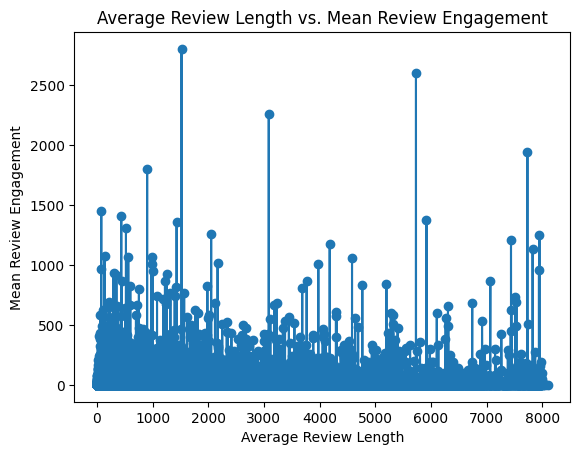

In [35]:
plt.plot(engagement_grouped_by_length_pandas["avg_review_length"], engagement_grouped_by_length_pandas["mean_review_engagement"], marker='o')
plt.title("Average Review Length vs. Mean Review Engagement")
plt.xlabel("Average Review Length")
plt.ylabel("Mean Review Engagement")
plt.show()

Plot Length of Review to COL_REVIEW_TOTAL_ENGAGEMENT and COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE

In [ ]:
grouped_review_metrics = clean_reviews_with_length_cleared.withColumn(
    "review_length", length(col(COL_REVIEW))
).groupBy("review_length").agg(
    mean(col(COL_REVIEW_TOTAL_ENGAGEMENT)).alias("avg_total_engagement"),
    mean(col(COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE)).alias("avg_comments_per_engagement"),
)

In [20]:
grouped_review_metrics_pandas = grouped_review_metrics.toPandas()
grouped_review_metrics_pandas = grouped_review_metrics_pandas.sort_values("review_length")

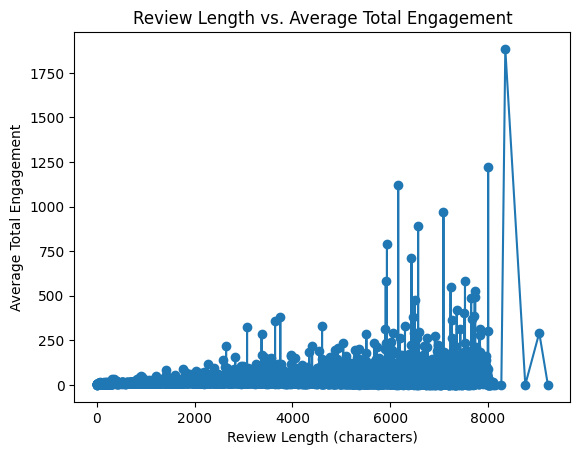

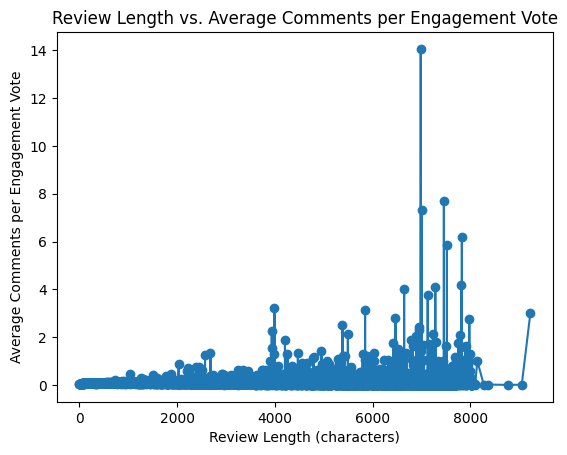

In [21]:
plt.plot(grouped_review_metrics_pandas["review_length"], grouped_review_metrics_pandas["avg_total_engagement"], marker='o')
plt.title("Review Length vs. Average Total Engagement")
plt.xlabel("Review Length (characters)")
plt.ylabel("Average Total Engagement")
plt.show()

plt.plot(grouped_review_metrics_pandas["review_length"], grouped_review_metrics_pandas["avg_comments_per_engagement"], marker='o')
plt.title("Review Length vs. Average Comments per Engagement Vote")
plt.xlabel("Review Length (characters)")
plt.ylabel("Average Comments per Engagement Vote")
plt.show()

Find relation between review length and how engaging it is

In [28]:
bin_size = 100

binned_grouped_review_metrics = clean_reviews_with_length_cleared.withColumn(
    "review_length_bin", (length(col("review")) / bin_size).cast("int") * bin_size
).groupBy("review_length_bin").agg(
    mean(col(COL_REVIEW_TOTAL_ENGAGEMENT)).alias("avg_total_engagement"),
    mean(col(COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE)).alias("avg_comments_per_engagement"),
)

In [30]:
binned_grouped_review_metrics_pandas = binned_grouped_review_metrics.toPandas()
binned_grouped_review_metrics_pandas = binned_grouped_review_metrics_pandas.sort_values("review_length_bin")

This shows that longer reviews usually have higher rates of comment engagement relative to voting and slightly larger average total engagement

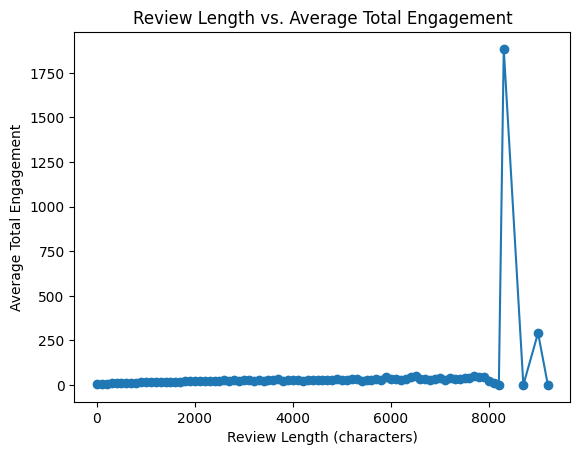

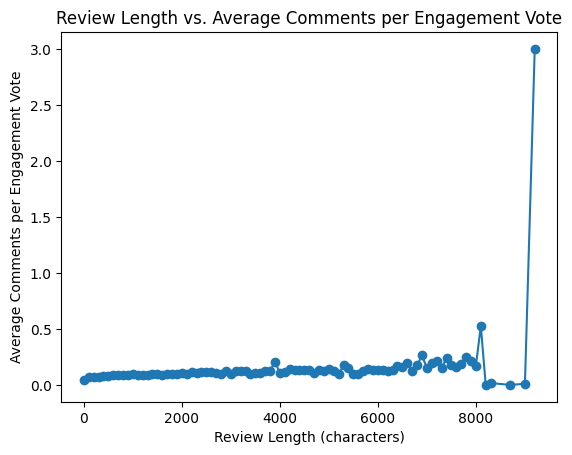

In [32]:
plt.plot(binned_grouped_review_metrics_pandas["review_length_bin"], binned_grouped_review_metrics_pandas["avg_total_engagement"], marker='o')
plt.title("Review Length vs. Average Total Engagement")
plt.xlabel("Review Length (characters)")
plt.ylabel("Average Total Engagement")
plt.show()

plt.plot(binned_grouped_review_metrics_pandas["review_length_bin"], binned_grouped_review_metrics_pandas["avg_comments_per_engagement"], marker='o')
plt.title("Review Length vs. Average Comments per Engagement Vote")
plt.xlabel("Review Length (characters)")
plt.ylabel("Average Comments per Engagement Vote")
plt.show()

Find relation between COL_REVIEWS_PER_GAME and COL_REVIEW_TOTAL_ENGAGEMENT

In [41]:
bin_size = 50

outlier_free_clean_reviews_with_length_cleared = clean_reviews_with_length_cleared.filter(col(COL_REVIEWS_PER_GAME) < 15)

binned_reviews_per_game = outlier_free_clean_reviews_with_length_cleared.withColumn(
    "reviews_per_game_bin", (col(COL_REVIEWS_PER_GAME) / bin_size) * bin_size
).groupBy("reviews_per_game_bin").agg(
    mean(col(COL_REVIEW_TOTAL_ENGAGEMENT) + col(COL_NUM_COMMENTS)).alias("avg_total_engagement"),
)

In [42]:
binned_reviews_per_game_pandas = binned_reviews_per_game.toPandas()
binned_reviews_per_game_pandas = binned_reviews_per_game_pandas.sort_values("reviews_per_game_bin")

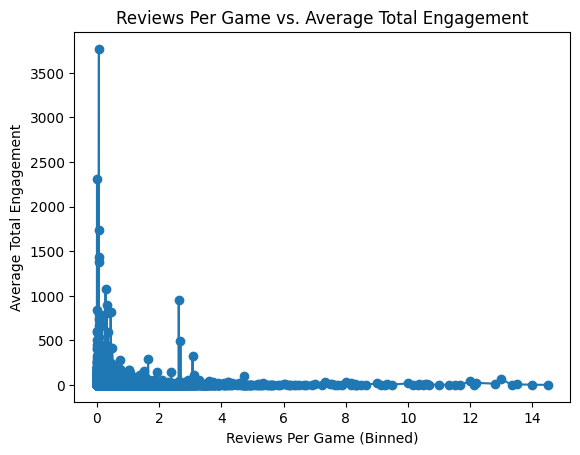

In [43]:
plt.plot(binned_reviews_per_game_pandas["reviews_per_game_bin"], binned_reviews_per_game_pandas["avg_total_engagement"], marker='o')
plt.title("Reviews Per Game vs. Average Total Engagement")
plt.xlabel("Reviews Per Game (Binned)")
plt.ylabel("Average Total Engagement")
plt.show()

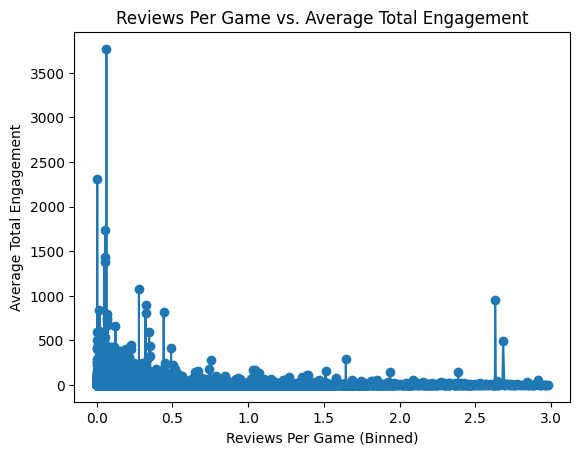

In [44]:
bin_size = 50

outlier_free_clean_reviews_with_length_cleared = clean_reviews_with_length_cleared.filter(col(COL_REVIEWS_PER_GAME) < 3)

binned_reviews_per_game = outlier_free_clean_reviews_with_length_cleared.withColumn(
    "reviews_per_game_bin", (col(COL_REVIEWS_PER_GAME) / bin_size) * bin_size
).groupBy("reviews_per_game_bin").agg(
    mean(col(COL_REVIEW_TOTAL_ENGAGEMENT) + col(COL_NUM_COMMENTS)).alias("avg_total_engagement"),
)

binned_reviews_per_game_pandas = binned_reviews_per_game.toPandas()
binned_reviews_per_game_pandas = binned_reviews_per_game_pandas.sort_values("reviews_per_game_bin")

plt.plot(binned_reviews_per_game_pandas["reviews_per_game_bin"], binned_reviews_per_game_pandas["avg_total_engagement"], marker='o')
plt.title("Reviews Per Game vs. Average Total Engagement")
plt.xlabel("Reviews Per Game (Binned)")
plt.ylabel("Average Total Engagement")
plt.show()

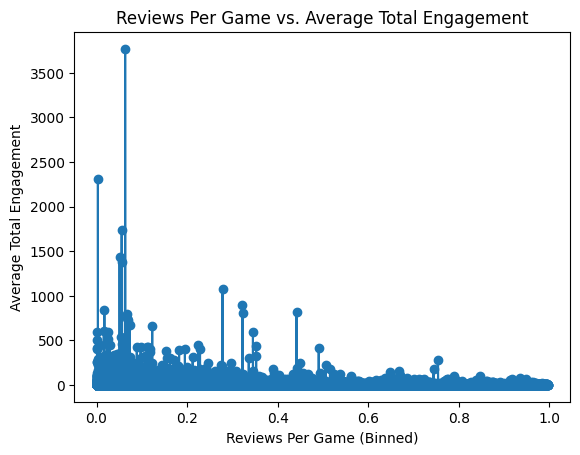

In [45]:
bin_size = 50

outlier_free_clean_reviews_with_length_cleared = clean_reviews_with_length_cleared.filter(col(COL_REVIEWS_PER_GAME) < 1)

binned_reviews_per_game = outlier_free_clean_reviews_with_length_cleared.withColumn(
    "reviews_per_game_bin", (col(COL_REVIEWS_PER_GAME) / bin_size) * bin_size
).groupBy("reviews_per_game_bin").agg(
    mean(col(COL_REVIEW_TOTAL_ENGAGEMENT) + col(COL_NUM_COMMENTS)).alias("avg_total_engagement"),
)

binned_reviews_per_game_pandas = binned_reviews_per_game.toPandas()
binned_reviews_per_game_pandas = binned_reviews_per_game_pandas.sort_values("reviews_per_game_bin")

plt.plot(binned_reviews_per_game_pandas["reviews_per_game_bin"], binned_reviews_per_game_pandas["avg_total_engagement"], marker='o')
plt.title("Reviews Per Game vs. Average Total Engagement")
plt.xlabel("Reviews Per Game (Binned)")
plt.ylabel("Average Total Engagement")
plt.show()

Find:   
Average Votes Up by Number of Reviews   
Average Votes Up by Number of Reviews   
Average Funny Votes by Number of Reviews    

In [ ]:
avg_reactions_by_reviews = clean_reviews.groupBy(COL_AUTHOR_NUM_REVIEWS).agg(
    mean(col(COL_NUM_VOTES_UP)).alias("avg_votes_up"),
    mean(col(COL_NUM_VOTES_FUNNY)).alias("avg_votes_funny"),
    mean(col(COL_NUM_COMMENTS)).alias("avg_comments"),
)

In [50]:
avg_reactions_by_reviews_pandas = avg_reactions_by_reviews.toPandas()
avg_reactions_by_reviews_pandas = avg_reactions_by_reviews_pandas.sort_values(COL_AUTHOR_NUM_REVIEWS)

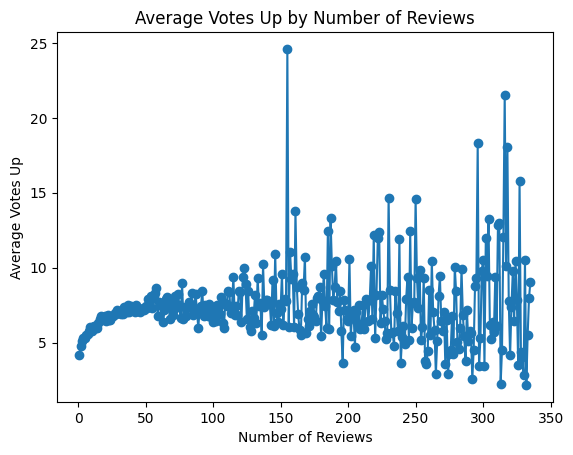

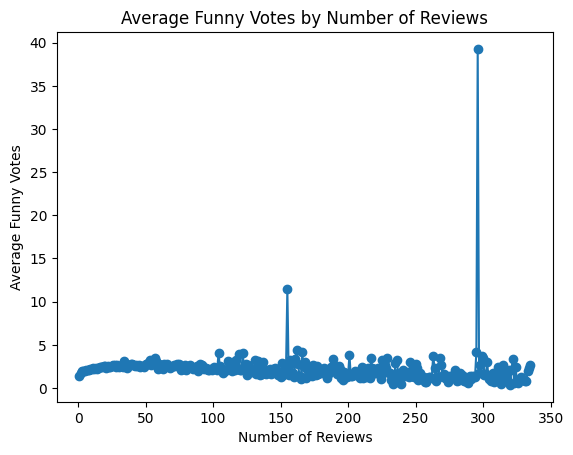

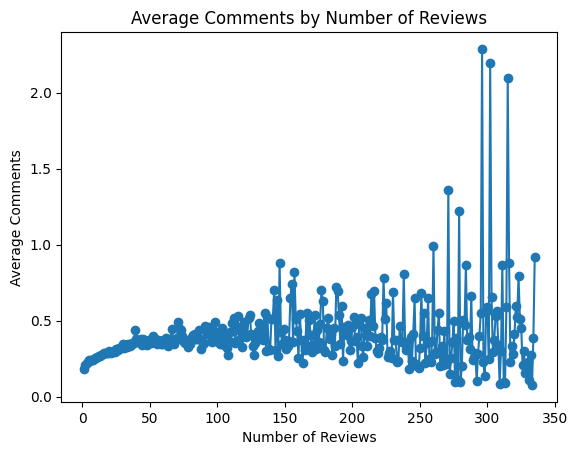

In [ ]:
plt.plot(avg_reactions_by_reviews_pandas[COL_AUTHOR_NUM_REVIEWS], avg_reactions_by_reviews_pandas["avg_votes_up"], marker='o')
plt.title("Average Votes Up by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Average Votes Up")
plt.show()

plt.plot(avg_reactions_by_reviews_pandas[COL_AUTHOR_NUM_REVIEWS], avg_reactions_by_reviews_pandas["avg_votes_funny"], marker='o')
plt.title("Average Funny Votes by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Average Funny Votes")
plt.show()

plt.plot(avg_reactions_by_reviews_pandas[COL_AUTHOR_NUM_REVIEWS], avg_reactions_by_reviews_pandas["avg_comments"], marker='o')
plt.title("Average Comments by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Average Comments")
plt.show()

# 3. Investigate bias

In [ ]:
# Group by purchase, free, and early access flags to calculate average percent positive reviews
purchase_trends = clean_reviews.groupBy(
    COL_IS_PURCHASED, COL_IS_RECEIVED_FOR_FREE, COL_IS_WRITTEN_DURING_EARLY_ACCESS
).agg(
    mean(col(COL_IS_VOTED_UP).cast("int")).alias("avg_percent_positive_reviews"),
)

In [ ]:
purchase_trends_pandas = purchase_trends.toPandas()

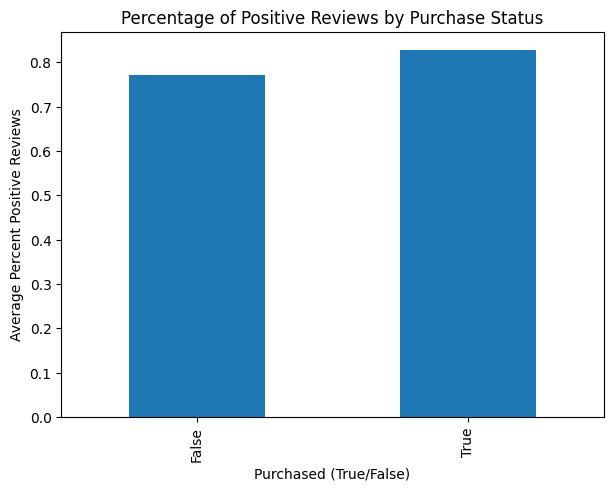

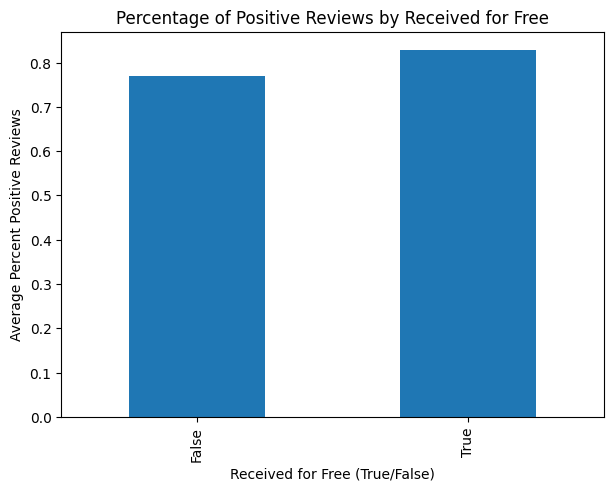

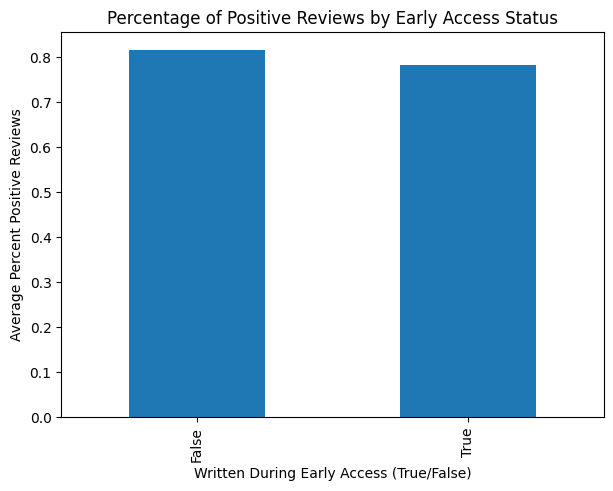

In [ ]:
purchased_trends = purchase_trends_pandas.groupby(COL_IS_PURCHASED)["avg_percent_positive_reviews"].mean()
purchased_trends.plot(kind="bar", figsize=(7, 5))
plt.title("Percentage of Positive Reviews by Purchase Status")
plt.xlabel("Purchased (True/False)")
plt.ylabel("Average Percent Positive Reviews")
plt.show()

free_trends = purchase_trends_pandas.groupby(COL_IS_RECEIVED_FOR_FREE)["avg_percent_positive_reviews"].mean()
free_trends.plot(kind="bar", figsize=(7, 5))
plt.title("Percentage of Positive Reviews by Received for Free")
plt.xlabel("Received for Free (True/False)")
plt.ylabel("Average Percent Positive Reviews")
plt.show()

early_access_trends = purchase_trends_pandas.groupby(COL_IS_WRITTEN_DURING_EARLY_ACCESS)["avg_percent_positive_reviews"].mean()
early_access_trends.plot(kind="bar", figsize=(7, 5))
plt.title("Percentage of Positive Reviews by Early Access Status")
plt.xlabel("Written During Early Access (True/False)")
plt.ylabel("Average Percent Positive Reviews")
plt.show()

After the analysis few key take aways for how the preprocessing should have been done:

1. Remove outliers on review length
2. Remove columns that are not used
3. Add user engagement metric as a new column
4. separate author data into separate table